In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# reading data from DB
feature_names = ["class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malig", "breast", "breast-quad", "irradiat"]

w = lambda x: 0 if x=='no-recurrence-events' else 1
df = pd.read_csv("breast-cancer.data", header=None, names=feature_names, na_values='?', true_values=['yes'], false_values=['no'], converters={0:w})

target = df['class']
features = df[feature_names[1:]]

# splitting data into train and test sets (80% and 20%)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True, stratify=target)

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# definig class encapsulating basic preprocessing pipeline - imputing missing data and encoding categorical features
class Preprocessor:
    def __init__(self, x_train):
        self._imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self._imputer.fit(x_train)
        
        self._feature_names = ["class", "age", "menopause", "tumor-size", "inv-nodes", "node-caps", "deg-malig", "breast", "breast-quad", "irradiat"]
        self._features_for_one_hot = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'breast', 'breast-quad']
        
        self._one_hot_encoder = OneHotEncoder(categories=[
            ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99'],
            ['lt40', 'ge40', 'premeno'],
            ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59'],
            ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39'],
            ['left', 'right'],
            ['left_up', 'left_low', 'right_up', 'right_low', 'central']
        ], sparse=False)

    def transform(self, data):
        imputed_data = pd.DataFrame(self._imputer.transform(data), columns=self._feature_names[1:])

        self._one_hot_encoder.fit(imputed_data[self._features_for_one_hot])
        one_hot = pd.DataFrame(self._one_hot_encoder.transform(imputed_data[self._features_for_one_hot]))
#         print(imputed_data.shape)
        imputed_data.drop(columns=self._features_for_one_hot, inplace=True)
        return_df = pd.concat([imputed_data, one_hot], axis=1)
        return return_df.astype(float)

In [16]:
# performing basic preprocessing
preprocessor = Preprocessor(X_train_raw)

X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

# utlity function for ploting confusion matrix found online
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.BuPu):
    """
    From scikit learn documentation
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="top",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

precision: 0.6

precision: 0.4444444444444444

precision: 0.6



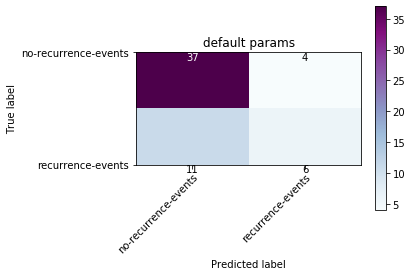

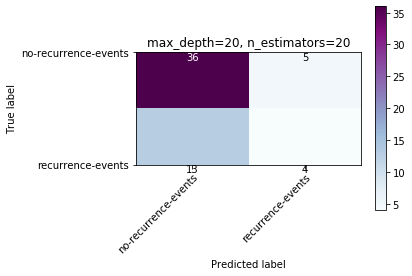

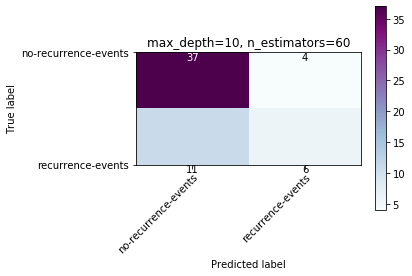

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix


# basic testing of RandomForest with couple different hyperparams

# default params
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"precision: {precision_score(y_test, preds)}")
plot_confusion_matrix(y_test, preds, classes=['no-recurrence-events', 'recurrence-events'], title='default params')
print()

# max_depth=20, n_estimators=20
clf = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=20)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"precision: {precision_score(y_test, preds)}")
# print(confusion_matrix(y_test, preds))
plot_confusion_matrix(y_test, preds, classes=['no-recurrence-events', 'recurrence-events'], title='max_depth=20, n_estimators=20')
print()


# max_depth=10, n_estimators=60
clf = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=60)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(f"precision: {precision_score(y_test, preds)}")
plot_confusion_matrix(y_test, preds, classes=['no-recurrence-events', 'recurrence-events'], title='max_depth=10, n_estimators=60')
print()



Grid search in progress...
Done
Best parameters:  {'class_weight': None, 'max_depth': 5, 'n_estimators': 63}
none test precision: 0.6854166666666667
Grid search in progress...
Done
Best parameters:  {'class_weight': None, 'max_depth': 3, 'n_estimators': 19}
normalization test precision: 0.7117988394584139
Grid search in progress...
Done
Best parameters:  {'class_weight': None, 'max_depth': 5, 'n_estimators': 63}
standarization test precision: 0.6854166666666667
Grid search in progress...
Done
Best parameters:  {'class_weight': None, 'max_depth': 3, 'n_estimators': 51}
pca_4 test precision: 0.62
Grid search in progress...
Done
Best parameters:  {'class_weight': None, 'max_depth': 3, 'n_estimators': 51}
pca_20 test precision: 0.62


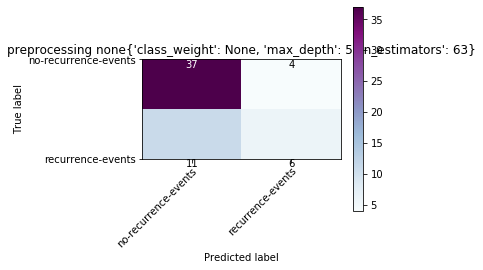

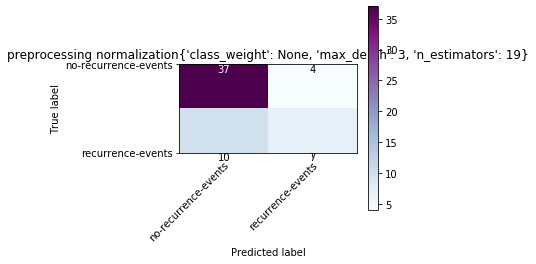

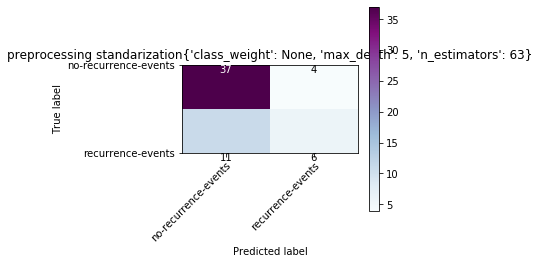

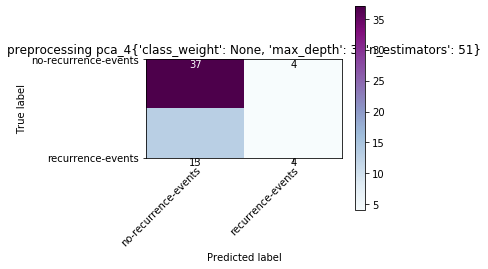

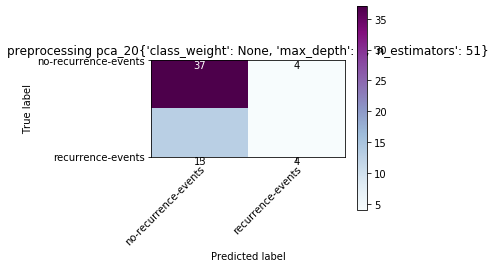

In [38]:
# testing normalization, standarization and PCA using GridSearchCV (10 fold validation)
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


preprocessing_steps = ['none', 'normalization', 'standarization', 'pca_4', 'pca_20']
hyperparam_grid = dict(
    n_estimators=range(1, 100, 2),
    max_depth=range(1, 40, 2),
    class_weight=[None, 'balanced']
)

for preproc in preprocessing_steps:
    if preproc == 'none':
        X_train_prep = X_train
        X_test_prep = X_test
    elif preproc == 'normalization':
        X_train_prep = normalize(X_train)
        X_test_prep = normalize(X_test)
    elif preproc == 'standarization':
        scaler = StandardScaler()
        X_train_prep = scaler.fit_transform(X_train)
        X_test_prep = scaler.transform(X_test)
    elif preproc == 'pca_4' or preproc == 'pca_6':
        if preproc == 'pca_4':
            n = 4
        else:
            n = 20
        pca = PCA(n_components=n)
        X_train_prep = pca.fit_transform(X_train)
        X_test_prep = pca.transform(X_test)
        
    grid = GridSearchCV(clf, hyperparam_grid, cv=10, n_jobs=-1, scoring='precision_macro')

    print("Grid search in progress...")
    grid.fit(X_train_prep, y_train)
    print("Done")

    print("Best parameters: ", grid.best_params_)

    clf = grid.best_estimator_
    
    preds = clf.predict(X_test_prep)
    print(f"{preproc} test precision: {precision_score(y_test, preds, average='macro')}")
    plot_confusion_matrix(y_test, preds, classes=['no-recurrence-events', 'recurrence-events'], title='preprocessing '+preproc+str(grid.best_params_))

    
        
        
        
